<a href="https://colab.research.google.com/github/twix-ps/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Prediction of Product Sales**


*   Author: Issa


###Project Overview

##Load and Inspect Data

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn import set_config
set_config(transform_output='pandas')



drive.mount('/content/drive')
fpath = "/content/drive/MyDrive/Dojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"
df = pd.read_csv(fpath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Clean Data

In [ ]:
# Getting the Rows & Columns count:
df.shape


(8523, 12)

In [ ]:
# Data types
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
# Checking for duplicates
duplicated_rows = df.duplicated()
duplicated_rows.sum()

# None found, so won't drop anything

0

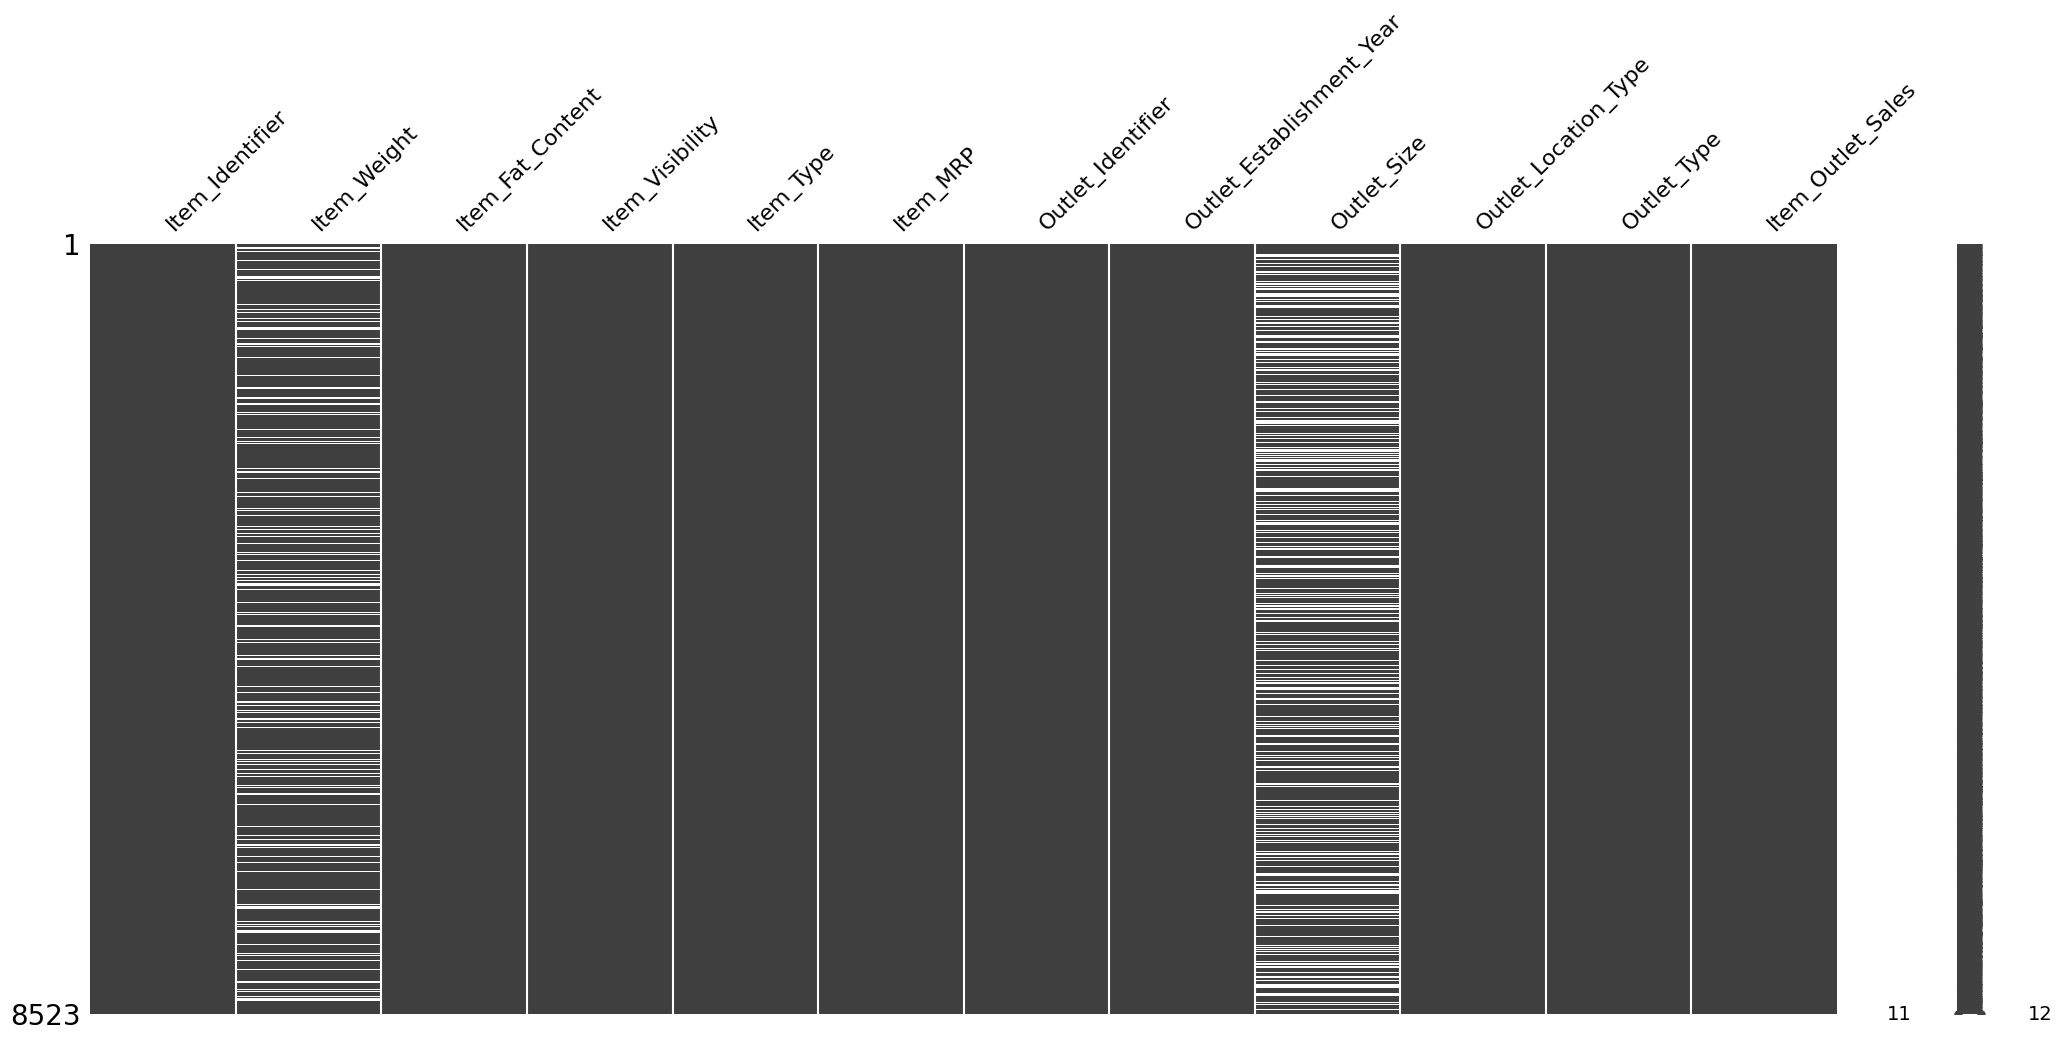

In [ ]:

# Visualize all the missing data

msno.matrix(df);

In [ ]:
# Checking for missing values and getting the percentages and sums
null_percent = df.isna().sum()/len(df) * 100
null_percent[null_percent>0]

# Item_Weight and Outlet_Size are missing in alot of rows, so replace with placeholder.

Item_Weight    17.165317
Outlet_Size    28.276428
dtype: float64

In [ ]:
# Re-check the missing values to ensure they're no longer missing
null_percent = df.isna().sum()/len(df) * 100
null_percent[null_percent>0]

Item_Weight    17.165317
Outlet_Size    28.276428
dtype: float64

In [ ]:
# Making sure all data is consistent
for column in df:
  print(f"{df[column].value_counts()}\n")

# Item_Fat_Content has mismatching values, so fix that:
replace_dict = {'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(replace_dict)

print(f"New values for Item_Fat_Content: {df['Item_Fat_Content'].value_counts()}")

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

Item_Weight
12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: count, Length: 415, dtype: int64

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Item_Visibility
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: count, Length: 7880, dtype: int64

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drin

In [ ]:
# Numeric columns list
numeric = df.select_dtypes(include=np.number).columns.tolist()

for name in numeric:
  print(f"{name}'s statistics: \nMean: {df[name].mean()}\nMinimum: {df[name].min()}\nMaximum:{df[name].max()}\n  ")

Item_Weight's statistics: 
Mean: 12.857645184135976
Minimum: 4.555
Maximum:21.35
  
Item_Visibility's statistics: 
Mean: 0.06613202877895108
Minimum: 0.0
Maximum:0.328390948
  
Item_MRP's statistics: 
Mean: 140.9927819781767
Minimum: 31.29
Maximum:266.8884
  
Outlet_Establishment_Year's statistics: 
Mean: 1997.8318667135984
Minimum: 1985
Maximum:2009
  
Item_Outlet_Sales's statistics: 
Mean: 2181.288913575032
Minimum: 33.29
Maximum:13086.9648
  


##Exploratory Data Analysis

In [ ]:
#Functions:

"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='rating',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='rating',
                           figsize=(6,4),
                           ):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


In [ ]:
used_cols = ['Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']
df = df[used_cols]

In [ ]:
feature = 'Outlet_Size'
df[feature].dtype

dtype('O')

<ipython-input-42-ca6a14bf2223>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


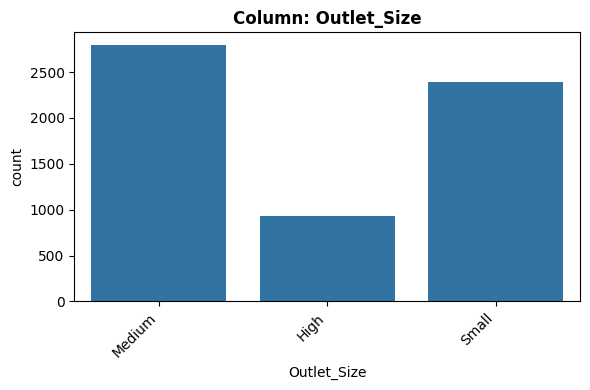

- NaN's Found: 2410 (28.28%)
- Unique Values: 3
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet_Size'}, xlabel='Outlet_Size', ylabel='count'>)

In [ ]:
explore_categorical(df, feature, 'Item_Outlet_Sales')

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - ordinal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 2410 Null values, 28.28%
  - Impute with mode based on the sales amount

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 3
  - Not high cardinality (not >10)

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.


<ipython-input-42-ca6a14bf2223>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Size vs. Item_Outlet_Sales'}, xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>)

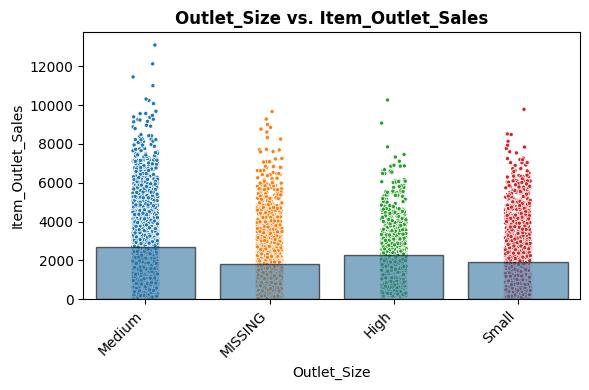

In [ ]:
plot_categorical_vs_target(df, 'Outlet_Size', 'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes it does, there is variability between the groups, even though some have similar means.

___

# Machine Learning

In [ ]:
# Reloading data
fpath = "/content/drive/MyDrive/Dojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"
df = pd.read_csv(fpath)

### Cleaning the data

In [ ]:
duplicated_rows = df.duplicated()
duplicated_rows.sum()

0

In [ ]:
# Making sure all data is consistent
for column in df:
  print(f"{df[column].value_counts()}\n")

# Item_Fat_Content has mismatching values, so fix that:
replace_dict = {'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(replace_dict)

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

Item_Weight
12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: count, Length: 415, dtype: int64

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Item_Visibility
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: count, Length: 7880, dtype: int64

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drin

### Preparing the target

In [ ]:
target = 'Item_Outlet_Sales'
X = df.drop(columns=[target, 'Item_Identifier'])
y = df[target]

### Creating the train test split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Making the pipelines and column transformer

In [ ]:
impute_median = SimpleImputer(strategy='median')
impute_missing = SimpleImputer(strategy='constant', fill_value='MISSING')
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

num_cols = X_train.select_dtypes(include='number').columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()



In [ ]:
num_pipe = make_pipeline(impute_median, scaler)
cat_pipe = make_pipeline(impute_missing, ohe)

num_tuple = ('numeric', num_pipe, num_cols)
cat_tuple = ('categorical', cat_pipe, cat_cols)

ct = ColumnTransformer(transformers=[num_tuple, cat_tuple])

In [ ]:
ct.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Item_Weight', 'Item_Visibility', 'Item_MRP',
                                  'Outlet_Establishment_Year']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Identifier', 'Outlet_Size',
                                  'Outlet_Location_Type', 'Outlet_Type'])])

In [ ]:
X_train_processed = ct.transform(X_train)
X_test_processed = ct.transform(X_test)

##Feature Inspection